In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import talib as ta
from datetime import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()
from sklearn.metrics import accuracy_score, r2_score

In [2]:
def get_prices(ticker, start_date, end_date):
    start = datetime.strptime(start_date, '%d/%m/%Y')
    end = datetime.strptime(end_date, '%d/%m/%Y')
    f = web.DataReader(ticker, 'morningstar', start, end)
    df = pd.DataFrame(f)
    
    return df

In [5]:
def stock_tester(ticker, start_date, end_date):
    
    prices = get_prices(ticker, '01/01/2010', '16/05/2018')
    prices.reset_index(inplace=True)
    prices = prices.rename(columns= {'Symbol':'symbol', 'Close':'close', 'High':'high', 'Low':'low', 'Volume' : 'volume', 'Date':'date', 'Open':'open'})
    prices.set_index(['symbol', 'date'], inplace=True)
    prices['EMA_20'] = ta.EMA(prices.close.values, 20)  # 20 day exponential moving average
    prices['EMA_50'] = ta.EMA(prices.close.values, 50)  # 50 day exponential moving average
    prices['EMA_200'] = ta.EMA(prices.close.values, 200)  # 200 day exponential moving average
    prices['EMA_ratio'] = prices['EMA_200']/prices['EMA_50'] # Ratio of moving average
    prices['RSI'] = ta.RSI(prices.close.values, 14)  # 14 day relative strength index
    prices['CCI'] = ta.CCI(high=prices.high.values, low=prices.low.values, close=prices.close.values, timeperiod=20)  # 20 day commodity channel index
    prices['Momentum'] = ta.MOM(prices.close.values, 10)  # 10 day rolling momentum
    prices['Stoch_fastk'], prices['Stoch_fastd'] = ta.STOCHF(high=prices.high.values, low=prices.low.values, close=prices.close.values, fastk_period=14, fastd_period=3)  # Stochastic fast indicator
    prices['OBV'] = ta.OBV(np.asarray(prices['close']), prices['volume'])  # On Balance Volume
    prices['bbandupper'], prices['bbandmiddle'], prices['bbandlower'] =  ta.BBANDS(prices.close.values)
    prices['perc_change']=(prices['close']- prices['close'].shift(1))/prices['close'].shift(1)  # Getting the daily percentage change
    prices['5dayvol'] = pd.rolling_std(prices['perc_change'],window=5)  # 5 day volatility
    prices['7_day_target'] = prices['close'].shift(-7)/prices['close']  # target of X days
    clean_prices = prices.loc[(prices['EMA_200'].notnull() & prices['7_day_target'].notnull())]
    clean_prices = clean_prices.reset_index()
    tree = RandomForestRegressor()
    x_train, x_test, y_train, y_test = train_test_split(clean_prices.loc[:,'EMA_ratio':'bbandlower'], clean_prices.loc[:,['7_day_target']], shuffle=False, test_size=90)
    tree.fit(x_train,y_train)
    y_pred = tree.predict(x_test)
    y_pred = pd.DataFrame({'ans': y_pred})
    test = pd.DataFrame({'close':clean_prices.tail(90).reset_index().close, 'ratio':y_pred['ans']})
    test['pred_price']= test['close'] * test['ratio']

    fig, ax1 = plt.subplots(figsize=(18,8))

    ax1.plot(y_pred['ans'], color='tab:blue')
    ax1.tick_params(labelrotation=85)
    ax1.grid(True)
    ax2 = ax1.twiny()
    ax2.plot(y_test['7_day_target'], color='tab:red')
    ax2.grid(True)

    fig, axa = plt.subplots(figsize=(18,8))
    axa.plot(clean_prices['close'].tail(90))

    axb = axa.twiny()
    axb.plot(test['pred_price'], color='tab:red')

    return tree.feature_importances_

C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).std()
C:\Users\Student\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


array([0.19882474, 0.11565607, 0.13090289, 0.0826989 , 0.0381606 ,
       0.07015601, 0.11249388, 0.09106394, 0.08485046, 0.0751925 ])

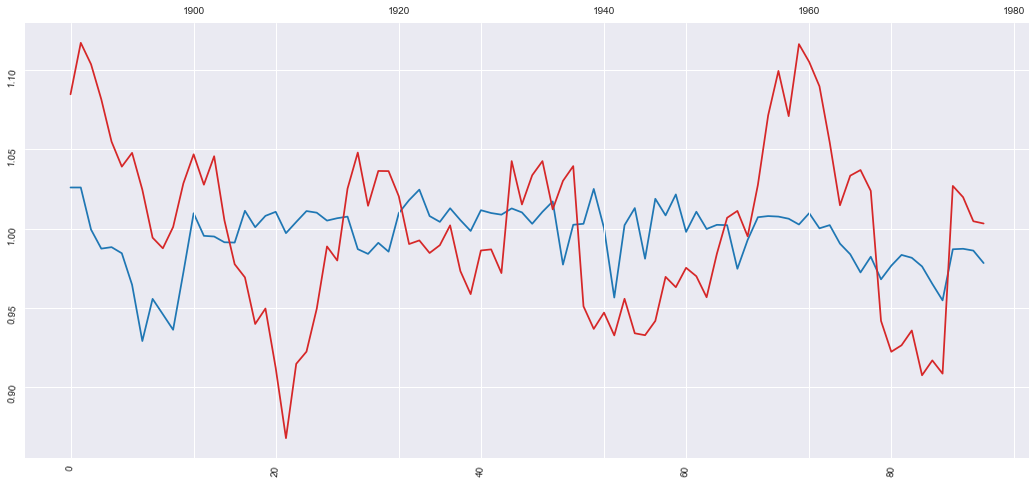

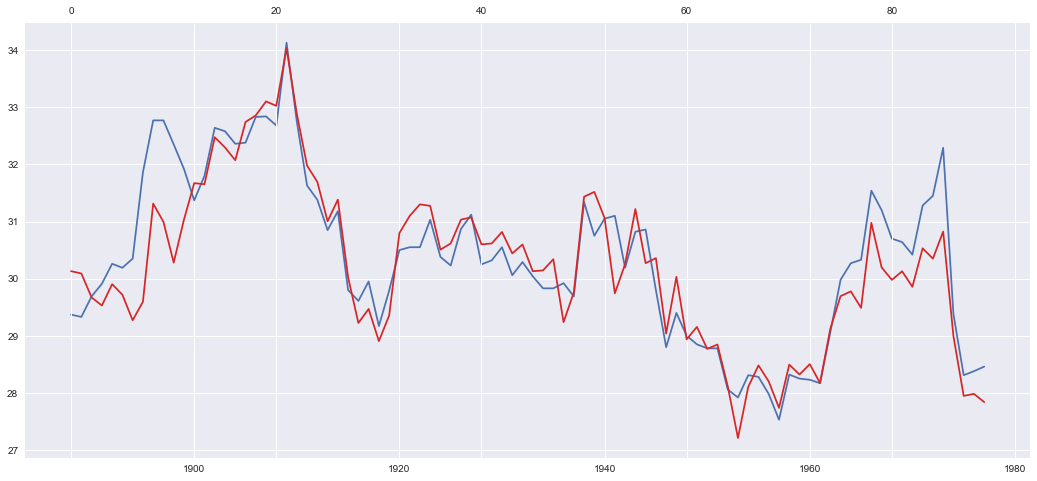

In [6]:
stock_tester('XRX', '01/01/2010', '16/05/2018')